In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
from snownlp import SnowNLP
from snownlp import sentiment
from snownlp import seg
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import re,math
import pandas as pd

In [2]:
#噓文需要跟主文章相反
def change_score(tag,word):
    if '噓' in tag:
        if word==1:
            return -1
        if word==-1:
            return 1
    if '→' in tag:
        return 0
    return word

In [3]:
#跑情緒分析模型，如果等於0.5代表不預測，大於0.5就代表看漲，小於0.5代表看跌
def model(x):
    s=SnowNLP(str(x).decode('utf-8'))
    if s.sentiments>=0.51:
        return 1
    if s.sentiments<=0.49:
        return -1
    if s.sentiments==0.5:
        return 0

In [4]:
#一整年的凱衛股價、成交量變化資料處理
stock_price=pd.read_csv('../data/5201.csv')
stock_price['data_ym']=stock_price['data_ym'].apply(lambda x: datetime.strftime(datetime.strptime(((str(int(x[0:3])+1911)+x[3:])),'%Y/%m/%d'),'%Y/%m/%d'))
stock_price['amount']=stock_price['amount'].apply(lambda x:int(re.sub(r',','',x)))

#計算凱衛分數
#將留言的分數讀取進來
message=pd.read_csv("../data/5201_push.csv")
message=message[['link','content','tag','author']]

#將文章分數讀取進來
article_score=pd.read_csv('../data/5201_article_by_hand.csv')
article_score=article_score[['link','score','dt']]
article_score.rename(index=str, columns={"dt":"data_ym"},inplace=True)

#用留言分數左聯集文章分數，KEY用LINK
message_score=pd.merge(message,article_score,how='left',on='link')
message_score['new']=message_score.apply(lambda x: change_score(x['tag'], x['score']), axis=1)
message_score['data_ym']=message_score['data_ym'].apply(lambda x: datetime.strftime(datetime.strptime(x,'%Y/%m/%d'),'%Y/%m/%d'))
message_score=message_score[['data_ym','new','content']]

#篩選上漲數量、中間數量、下跌數量
down_pop=message_score[message_score['new']==-1]
middle_pop=message_score[message_score['new']==0]
top_pop=message_score[message_score['new']==1]

#只針對中立的文本做情緒分析
middle_pop['new']=middle_pop['content'].apply(model)

#將中立文本換算的結果，合併回去，成為最後
final_message=pd.concat([top_pop,middle_pop,down_pop])

#產生最後分析的data_mart
message_dm=final_message.groupby(['data_ym','new']).count().unstack(level=-1)
message_dm=message_dm.reset_index()
message=pd.DataFrame({'data_ym':message_dm['data_ym'],
                      'down':message_dm['content'][-1.0],
                      'top':message_dm['content'][1.0],})
message['final']=message['top']-message['down']
message['total']=message['top']+message['down']
final=pd.merge(stock_price,message,how='left',on='data_ym')
final.head()


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,data_ym,start,amount,down,top,final,total
0,2016/10/03,18.20,550,NaN,NaN,NaN,NaN
1,2016/10/04,21.55,8468,NaN,NaN,NaN,NaN
2,2016/10/05,20.55,1331,NaN,NaN,NaN,NaN
3,2016/10/06,20.80,2517,26.0,25.0,-1.0,51.0
4,2016/10/07,22.40,1945,NaN,NaN,NaN,NaN


In [5]:
#日期遞延一天
for i in range(0,len(final)-1,1):
    final['data_ym'][i]=final['data_ym'][i+1]
print final.head()

      data_ym  start  amount  down   top  final  total
0  2016/10/04  18.20     550   NaN   NaN    NaN    NaN
1  2016/10/05  21.55    8468   NaN   NaN    NaN    NaN
2  2016/10/06  20.55    1331   NaN   NaN    NaN    NaN
3  2016/10/07  20.80    2517  26.0  25.0   -1.0   51.0
4  2016/10/11  22.40    1945   NaN   NaN    NaN    NaN


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
#交易策略買進

money=100000  #本金
tickets=0     #股票張數
buy_money=0   #當時購買金額
limit=0.05    #設定進出門檻上下界
low_limit=0   #獲利出場門檻
high_limit=0  #虧損出場門檻 
x_date=[]     #購買的日期
x_price=[]    #購買價格
y_date=[]     #賣出日期
y_price=[]    #賣出價格
profit_total=0  #全部獲利金額
loss_total=0    #全部虧損金額

def buy(money,start):
    tickets=0
    tickets=math.floor(money/(start*1000))
    money=money-((start*tickets*1000)*1.006)
    return int(money),int(tickets),start

def sell(money,tickets,start,buy_money):
    money=(tickets*start*1000)+money
    profit=(start-buy_money)*1000*tickets
    print '獲利金額' + str(profit)
    tickets=0
    buy_money=0
    return tickets,money,buy_money,profit

print 'log---------------------------------------------------------------'

for index,row in final.iterrows():
    print row['data_ym']+"開盤價"+str(row['start']),"現在金額"+str(money),"現在持有張數"+str(tickets),"買進當時股價"+str(buy_money)
    
    #進場條件:只要當天有討論就進場
    if tickets==0 and row['total']>1 :
        money,tickets,buy_money=buy(money,row['start'])
        print row['data_ym']+"買進",str(tickets)+'張'
        low_limit=buy_money*(1-limit)
        high_limit=buy_money*(1+limit)
        x_date.append(index)
        x_price.append(row['start'])
        continue
    #出場條件:高於獲利出場門檻，低於虧損出場門檻
    if tickets>0 and (row['start']>high_limit or row['start']<low_limit):
        print row['data_ym']+"賣出",str(tickets)+'張'
        tickets,money,buy_money,profit=sell(money,tickets,row['start'],buy_money)
        if profit>0:
            profit_total= profit_total+profit
        if profit<0:
            loss_total=loss_total+profit
        y_date.append(index)
        y_price.append(row['start'])

print '------------------------------------------------------------------'
print "總共獲利金額"+str(profit_total)
print "總共虧損金額"+str(loss_total)

log---------------------------------------------------------------
2016/10/04開盤價18.2 現在金額100000 現在持有張數0 買進當時股價0
2016/10/05開盤價21.55 現在金額100000 現在持有張數0 買進當時股價0
2016/10/06開盤價20.55 現在金額100000 現在持有張數0 買進當時股價0
2016/10/07開盤價20.8 現在金額100000 現在持有張數0 買進當時股價0
2016/10/07買進 4張
2016/10/11開盤價22.4 現在金額16300 現在持有張數4 買進當時股價20.8
2016/10/11賣出 4張
獲利金額6400.0
2016/10/12開盤價22.5 現在金額105900.0 現在持有張數0 買進當時股價0
2016/10/13開盤價22.05 現在金額105900.0 現在持有張數0 買進當時股價0
2016/10/14開盤價24.1 現在金額105900.0 現在持有張數0 買進當時股價0
2016/10/17開盤價23.45 現在金額105900.0 現在持有張數0 買進當時股價0
2016/10/18開盤價24.2 現在金額105900.0 現在持有張數0 買進當時股價0
2016/10/18買進 4張
2016/10/19開盤價24.5 現在金額8519 現在持有張數4 買進當時股價24.2
2016/10/20開盤價25.45 現在金額8519 現在持有張數4 買進當時股價24.2
2016/10/20賣出 4張
獲利金額5000.0
2016/10/21開盤價25.15 現在金額110319.0 現在持有張數0 買進當時股價0
2016/10/24開盤價25.3 現在金額110319.0 現在持有張數0 買進當時股價0
2016/10/24買進 4張
2016/10/25開盤價26.1 現在金額8511 現在持有張數4 買進當時股價25.3
2016/10/26開盤價26.8 現在金額8511 現在持有張數4 買進當時股價25.3
2016/10/26賣出 4張
獲利金額6000.0
2016/10/27開盤價29.55 現在金額115711.0 現在持有張數0 買進當時股價0
2016/10/28

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


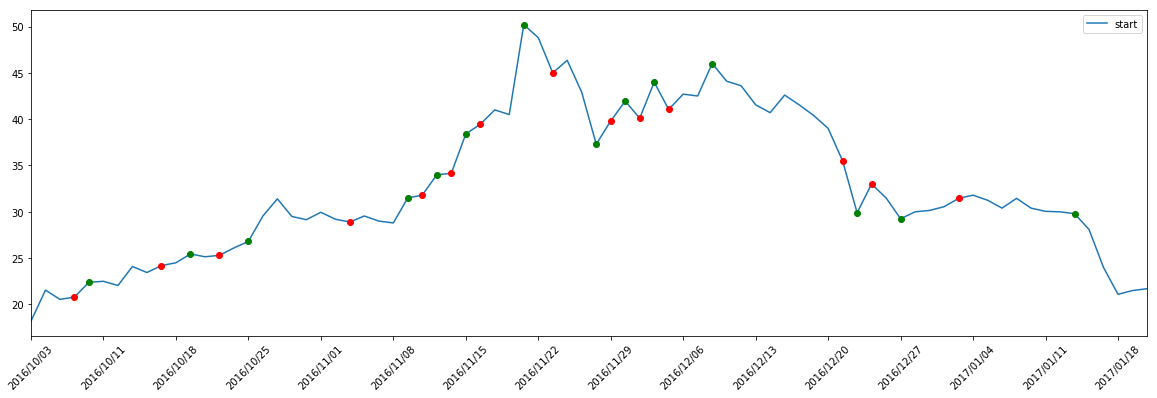

In [7]:
#產生交意圖
def thin_xticks(ax,ticklabels,tick_gap=5,rotation=45):
    ticks=ax.xaxis.get_ticklocs()
    ax.xaxis.set_ticks(ticks[::tick_gap])
    ax.xaxis.set_ticklabels(ticklabels[::tick_gap],rotation=rotation)
    ax.figure.show()

stock_price['data_ym']=stock_price['data_ym'].apply(lambda x:str(x))
data_ym=stock_price['data_ym'].tolist()
picture=stock_price[['data_ym','start']]
plt=picture.plot(figsize=(20,6))
ticks=np.array(range(len(data_ym)))
plt.set_xticks(ticks)
thin_xticks(plt,data_ym)

plt.plot(x_date,x_price,'ro',c='red')
plt.plot(y_date,y_price,'ro',c='green')

In [8]:
#交易策略買進

money=100000  #本金
tickets=0     #股票張數
buy_money=0   #當時購買金額
limit=0.05    #設定進出門檻上下界
low_limit=0   #獲利出場門檻
high_limit=0  #虧損出場門檻 
x_date=[]     #購買的日期
x_price=[]    #購買價格
y_date=[]     #賣出日期
y_price=[]    #賣出價格
profit_total=0  #全部獲利金額
loss_total=0    #全部虧損金額


def buy(money,start):
    tickets=0
    tickets=math.floor(money/(start*1000))
    money=money-((start*tickets*1000)*1.006)
    return int(money),int(tickets),start

def sell(money,tickets,start,buy_money):
    money=(tickets*start*1000)+money
    profit=(start-buy_money)*1000*tickets
    print '獲利金額' + str(profit)
    tickets=0
    buy_money=0
    return tickets,money,buy_money,profit

print 'log---------------------------------------------------------------'

for index,row in final.iterrows():
    print row['data_ym']+"開盤價"+str(row['start']),"現在金額"+str(money),"現在持有張數"+str(tickets),"買進當時股價"+str(buy_money)

    #買進條件:當天有發文且看漲文本數量大於看跌文本數量
    if tickets==0 and row['total']>1 and row['top']>row['down'] and row['total']>10:
        money,tickets,buy_money=buy(money,row['start'])
        print row['data_ym']+"買進",str(tickets)+'張'
        low_limit=buy_money*(1-limit)
        high_limit=buy_money*(1+limit)
        x_date.append(index)
        x_price.append(row['start'])
        continue
        
    #出場條件看跌文本大於看漲文本，或是高於獲利出場門檻，低於虧損出場門檻
    if tickets>0 and (row['start']>high_limit or row['start']<low_limit or row['top']<row['down']):
        print row['data_ym']+"賣出",str(tickets)+'張'
        tickets,money,buy_money,profit=sell(money,tickets,row['start'],buy_money)
        if profit>0:
            profit_total= profit_total+profit
        if profit<0:
            loss_total=loss_total+profit
        y_date.append(index)
        y_price.append(row['start'])

print '------------------------------------------------------------------'
print "總共獲利金額"+str(profit_total)
print "總共虧損金額"+str(loss_total)

log---------------------------------------------------------------
2016/10/04開盤價18.2 現在金額100000 現在持有張數0 買進當時股價0
2016/10/05開盤價21.55 現在金額100000 現在持有張數0 買進當時股價0
2016/10/06開盤價20.55 現在金額100000 現在持有張數0 買進當時股價0
2016/10/07開盤價20.8 現在金額100000 現在持有張數0 買進當時股價0
2016/10/11開盤價22.4 現在金額100000 現在持有張數0 買進當時股價0
2016/10/12開盤價22.5 現在金額100000 現在持有張數0 買進當時股價0
2016/10/13開盤價22.05 現在金額100000 現在持有張數0 買進當時股價0
2016/10/14開盤價24.1 現在金額100000 現在持有張數0 買進當時股價0
2016/10/17開盤價23.45 現在金額100000 現在持有張數0 買進當時股價0
2016/10/18開盤價24.2 現在金額100000 現在持有張數0 買進當時股價0
2016/10/19開盤價24.5 現在金額100000 現在持有張數0 買進當時股價0
2016/10/20開盤價25.45 現在金額100000 現在持有張數0 買進當時股價0
2016/10/21開盤價25.15 現在金額100000 現在持有張數0 買進當時股價0
2016/10/24開盤價25.3 現在金額100000 現在持有張數0 買進當時股價0
2016/10/25開盤價26.1 現在金額100000 現在持有張數0 買進當時股價0
2016/10/26開盤價26.8 現在金額100000 現在持有張數0 買進當時股價0
2016/10/27開盤價29.55 現在金額100000 現在持有張數0 買進當時股價0
2016/10/28開盤價31.4 現在金額100000 現在持有張數0 買進當時股價0
2016/10/31開盤價29.5 現在金額100000 現在持有張數0 買進當時股價0
2016/11/01開盤價29.15 現在金額100000 現在持有張數0 買進當時股價0
2016/11/02開盤價29.95 現在金額10

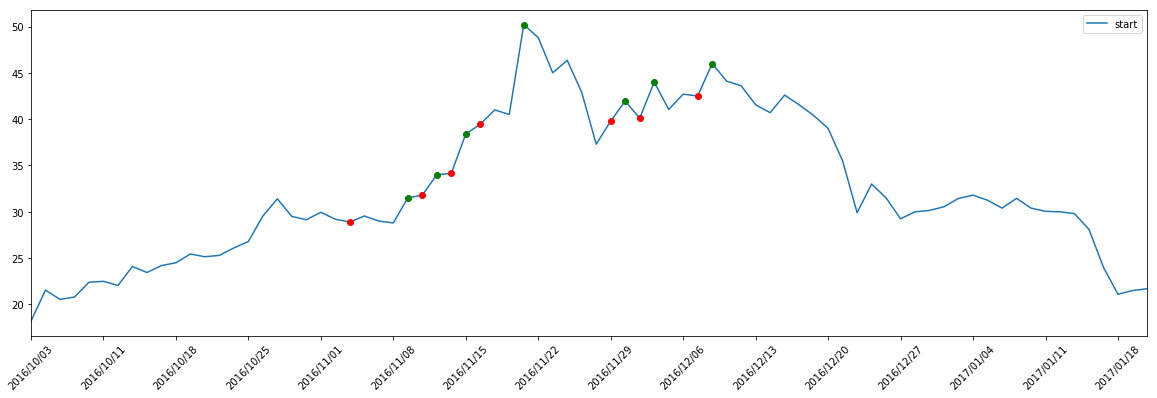

In [9]:
#產生交易圖
def thin_xticks(ax,ticklabels,tick_gap=5,rotation=45):
    ticks=ax.xaxis.get_ticklocs()
    ax.xaxis.set_ticks(ticks[::tick_gap])
    ax.xaxis.set_ticklabels(ticklabels[::tick_gap],rotation=rotation)
    ax.figure.show()
stock_price['data_ym']=stock_price['data_ym'].apply(lambda x:str(x))
data_ym=stock_price['data_ym'].tolist()
picture=stock_price[['data_ym','start']]
plt=picture.plot(figsize=(20,6))
ticks=np.array(range(len(data_ym)))
plt.set_xticks(ticks)
thin_xticks(plt,data_ym)

plt.plot(x_date,x_price,'ro',c='red')
plt.plot(y_date,y_price,'ro',c='green')

In [10]:
#交易策略買進

money=100000  #本金
tickets=0     #股票張數
margin=0       #融券張數
buy_money=0   #當時購買金額
buy_margin=0  #借券當時的價格

limit=0.05    #設定進出門檻上下界
low_limit=0   #獲利出場門檻
high_limit=0  #虧損出場門檻
low_limit_margin=0 #融券獲利出場條件
high_limit_margin=0 #融券虧損出場條件

x_date=[]     #多單進場的日期
x_price=[]    #多單進場價格
y_date=[]     #空單進場日期
y_price=[]    #空單進場價格

profit_total=0  #全部多單獲利金額
loss_total=0    #全部多單虧損金額
margin_profit_total=0  #全部空單獲利金額
margin_loss_total=0    #全部空單虧損金額


def buy(money,start):
    tickets=0
    tickets=math.floor(money/(start*1000))
    money=money-((start*tickets*1000)*1.006)
    return int(money),int(tickets),start

def sell(money,tickets,start,buy_money):
    money=(tickets*start*1000)+money
    profit=(start-buy_money)*1000*tickets
    tickets=0
    buy_money=0
    return tickets,money,buy_money,profit

#借券
def margin_buy_f(money,start):
    margin=0
    margin=math.floor(money/(start*1000))
    money=money-((start*margin*1000)*1.007)
    return int(money),int(margin),start

#借券歸還
def margin_sell_f(money,margin,start,buy_margin):
    profit=-1*(start-buy_margin)*1000*margin
    money=(margin*buy_margin*1000)+money+profit
    margin=0
    buy_margin=0
    return margin,money,buy_margin,profit

print 'log---------------------------------------------------------------'

for index,row in final.iterrows():
    print row['data_ym']+"開盤價"+str(row['start']),"現在金額"+str(money),"現在持有張數"+str(tickets),"買進當時股價 "+str(buy_money)+" 融券數量 "+str(margin)+"融券價格"+str(buy_margin)
    
    #多單條件:當天有發文且看漲文本數量大於看跌文本數量
    
    if tickets==0 and row['total']>1 and row['top']>row['down']:
        #沒券情況:
        if margin==0:
            money,tickets,buy_money=buy(money,row['start'])
            print row['data_ym']+"買進",str(tickets)+'張'
            #設定多單進出場門檻
            low_limit=buy_money*(1-limit)
            high_limit=buy_money*(1+limit)
            #紀錄多單進場價格、日期
            x_date.append(index)
            x_price.append(row['start'])
            continue
        #有券情況:
        if margin>0:
            #空單出場
            margin,money,buy_margin,profit=margin_sell_f(money,margin,row['start'],buy_margin)
            print "融券獲利"+str(profit)
            print '現在本金'+str(money)
            y_date.append(index)
            y_price.append(row['start'])                   
            #計算空單獲利與虧損
            if profit>0:
                margin_profit_total= margin_profit_total+profit
            if profit<0:
                margin_loss_total=margin_loss_total+profit            
               
            #多單進場
            money,tickets,buy_money=buy(money,row['start'])
            print row['data_ym']+"買進",str(tickets)+'張'
            
            #設定多單進出場門檻
            low_limit=buy_money*(1-limit)
            high_limit=buy_money*(1+limit)
            
            #紀錄多單進場價格、日期 
            x_date.append(index)
            x_price.append(row['start'])
            continue
      
        
    #空單條件:1.沒有券2.當天有發文且看跌文本多於看漲文本
    if margin==0 and (row['top']<row['down']) and row['total']>1:
        #有股票
        if tickets>0:
            print row['data_ym']+"賣出",str(tickets)+'張'
            #多單獲利了解
            tickets,money,buy_money,profit=sell(money,tickets,row['start'],buy_money)
            print '現在本金'+str(money)
            #計算多單累積盈虧
            if profit>0:
                profit_total= profit_total+profit
            if profit<0:
                loss_total=loss_total+profit
            
            #空單進場
            money,margin,buy_margin=margin_buy_f(money,row['start'])
            print  '剩下本金'+str(money),'融券數量'+str(margin),'融券時價格'+str(buy_margin)
            #設定空單進出場條件
            low_limit_margin=buy_margin*(1-limit)
            high_limit_margin=buy_margin*(1+limit)
            #紀錄空單時間、股價
            y_date.append(index)
            y_price.append(row['start'])            
            continue
        #沒有股票
        if tickets==0:
            #空券進場
            money,margin,buy_margin=margin_buy_f(money,row['start'])
            print  '剩下本金'+str(money),'融券數量'+str(margin),'融券時價格'+str(buy_margin)
            #設定空單進出場條件
            low_limit_margin=buy_margin*(1-limit)
            high_limit_margin=buy_margin*(1+limit)
            #紀錄空單時間、股價
            y_date.append(index)
            y_price.append(row['start'])        
    #空單出場條件:
    if margin>0 and (row['start']<low_limit_margin or row['start']>high_limit_margin):
        margin,money,buy_margin,profit=margin_sell_f(money,margin,row['start'],buy_margin)
        print "融券獲利"+str(profit)

        #計算空單獲利與虧損
        if profit>0:
            margin_profit_total= margin_profit_total+profit
        if profit<0:
            margin_loss_total=margin_loss_total+profit            
            money,tickets,buy_money=buy(money,row['start'])
   
    #多單出場條件:
    if tickets>0 and (row['start']<low_limit or row['start']>high_limit):
        tickets,money,buy_money,profit=sell(money,tickets,row['start'],buy_money)
        print "多單獲利"+str(profit)
        
        #計算多單獲利與虧損
        if profit>0:
            profit_total= profit_total+profit
        if profit<0:
            loss_total=loss_total+profit

print '------------------------------------------------------------------'
print "總共多單獲利金額"+str(profit_total)
print "總共多單虧損金額"+str(loss_total)
print "總共借券獲利金額"+str(margin_profit_total)
print "總共借券虧損金額"+str(margin_loss_total)

log---------------------------------------------------------------
2016/10/04開盤價18.2 現在金額100000 現在持有張數0 買進當時股價 0 融券數量 0融券價格0
2016/10/05開盤價21.55 現在金額100000 現在持有張數0 買進當時股價 0 融券數量 0融券價格0
2016/10/06開盤價20.55 現在金額100000 現在持有張數0 買進當時股價 0 融券數量 0融券價格0
2016/10/07開盤價20.8 現在金額100000 現在持有張數0 買進當時股價 0 融券數量 0融券價格0
剩下本金16217 融券數量4 融券時價格20.8
2016/10/11開盤價22.4 現在金額16217 現在持有張數0 買進當時股價 0 融券數量 4融券價格20.8
融券獲利-6400.0
多單獲利0.0
2016/10/12開盤價22.5 現在金額92479.0 現在持有張數0 買進當時股價 0 融券數量 0融券價格0
2016/10/13開盤價22.05 現在金額92479.0 現在持有張數0 買進當時股價 0 融券數量 0融券價格0
2016/10/14開盤價24.1 現在金額92479.0 現在持有張數0 買進當時股價 0 融券數量 0融券價格0
2016/10/17開盤價23.45 現在金額92479.0 現在持有張數0 買進當時股價 0 融券數量 0融券價格0
2016/10/18開盤價24.2 現在金額92479.0 現在持有張數0 買進當時股價 0 融券數量 0融券價格0
剩下本金19370 融券數量3 融券時價格24.2
2016/10/19開盤價24.5 現在金額19370 現在持有張數0 買進當時股價 0 融券數量 3融券價格24.2
2016/10/20開盤價25.45 現在金額19370 現在持有張數0 買進當時股價 0 融券數量 3融券價格24.2
融券獲利-3750.0
多單獲利0.0
2016/10/21開盤價25.15 現在金額87761.0 現在持有張數0 買進當時股價 0 融券數量 0融券價格0
2016/10/24開盤價25.3 現在金額87761.0 現在持有張數0 買進當時股價 0 融券數量 0融券價格0
剩下本金11329 

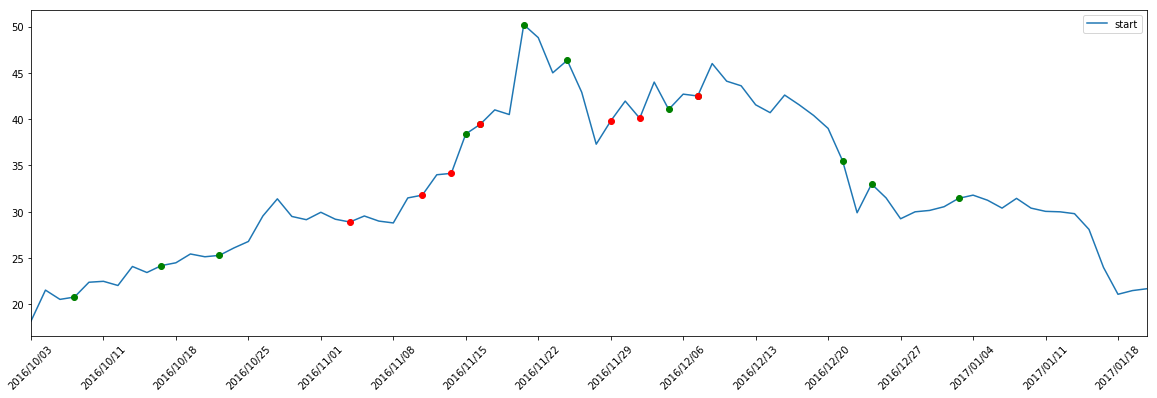

In [11]:
def thin_xticks(ax,ticklabels,tick_gap=5,rotation=45):
    ticks=ax.xaxis.get_ticklocs()
    ax.xaxis.set_ticks(ticks[::tick_gap])
    ax.xaxis.set_ticklabels(ticklabels[::tick_gap],rotation=rotation)
    ax.figure.show()
stock_price['data_ym']=stock_price['data_ym'].apply(lambda x:str(x))
data_ym=stock_price['data_ym'].tolist()
picture=stock_price[['data_ym','start']]
plt=picture.plot(figsize=(20,6))
ticks=np.array(range(len(data_ym)))
plt.set_xticks(ticks)
thin_xticks(plt,data_ym)


plt.plot(y_date,y_price,'ro',c='green')
plt.plot(x_date,x_price,'ro',c='red')